In [1]:
import keras
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, mean_squared_error

import pandas as pd # importing the pandas library and naming it as pd
import numpy as np # import library for array processing
import matplotlib.pyplot as plt # import library for plotting
%matplotlib inline
import seaborn as sns

import dask.dataframe as dd

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df_demand = pd.read_csv('data/demand.csv')

df_mrim = pd.read_csv('data/mrim_new.csv')

In [3]:
df_demand['SETTLEMENTDATE'] = pd.to_datetime(df_demand['SETTLEMENTDATE'])
df_mrim['SETTLEMENTDATE'] = pd.to_datetime(df_mrim['SETTLEMENTDATE'])

df_demand['SETTLEMENTDATE'] = df_demand['SETTLEMENTDATE'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_mrim['SETTLEMENTDATE'] = df_mrim['SETTLEMENTDATE'].dt.strftime('%d-%m-%Y %H:%M:%S')

df_demand['SETTLEMENTDATE'] = pd.to_datetime(df_demand['SETTLEMENTDATE'])
df_mrim['SETTLEMENTDATE'] = pd.to_datetime(df_mrim['SETTLEMENTDATE'])

In [4]:
df_demand

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2016-01-01 00:30:00,5197.34,35.52
1,2016-01-01 01:00:00,4934.54,38.29
2,2016-01-01 01:30:00,4721.32,29.30
3,2016-01-01 02:00:00,4541.24,31.28
4,2016-01-01 02:30:00,4344.18,23.87
...,...,...,...
83563,2020-10-06 22:00:00,4806.73,44.52
83564,2020-10-06 22:30:00,4635.19,44.08
83565,2020-10-06 23:00:00,4549.08,21.94
83566,2020-10-06 23:30:00,4720.06,47.31


In [5]:
df_mrim

,ServiceProvider,SETTLEMENTDATE,DAILYT,MRIMReading
0,CITIPOWER,2016-01-01 00:30:00,4683409.892,112853.074
1,CITIPOWER,2016-01-01 01:00:00,4683409.892,104363.755
2,CITIPOWER,2016-01-01 01:30:00,4683409.892,97343.792
3,CITIPOWER,2016-01-01 02:00:00,4683409.892,91889.809
4,CITIPOWER,2016-01-01 02:30:00,4683409.892,87655.710
...,...,...,...,...
328555,VICAGL,2019-09-30 22:00:00,4916430.836,137761.772
328556,VICAGL,2019-09-30 22:30:00,4916430.836,125253.789
328557,VICAGL,2019-09-30 23:00:00,4916430.836,112555.101
328558,VICAGL,2019-09-30 23:30:00,4916430.836,115577.986


In [6]:
merged = pd.merge(df_demand, df_mrim, how='left', on=['SETTLEMENTDATE'])
merged['Date'] = [d.date() for d in merged['SETTLEMENTDATE']]
merged['Time'] = [d.time() for d in merged['SETTLEMENTDATE']]
merged['Date'] = pd.to_datetime(merged['Date'])
# merged['Time'] = pd.to_datetime(merged['Time'])

In [7]:
merged

,SETTLEMENTDATE,TOTALDEMAND,RRP,ServiceProvider,DAILYT,MRIMReading,Date,Time
0,2016-01-01 00:30:00,5197.34,35.52,CITIPOWER,4.683410e+06,112853.074,2016-01-01,00:30:00
1,2016-01-01 00:30:00,5197.34,35.52,POWERCOR,1.304059e+07,323325.791,2016-01-01,00:30:00
2,2016-01-01 00:30:00,5197.34,35.52,TXU,7.254505e+06,185141.044,2016-01-01,00:30:00
3,2016-01-01 00:30:00,5197.34,35.52,UNITED,9.311606e+06,240733.933,2016-01-01,00:30:00
4,2016-01-01 00:30:00,5197.34,35.52,VICAGL,4.167068e+06,105782.888,2016-01-01,00:30:00
...,...,...,...,...,...,...,...,...
346411,2020-10-06 22:00:00,4806.73,44.52,NaN,NaN,NaN,2020-10-06,22:00:00
346412,2020-10-06 22:30:00,4635.19,44.08,NaN,NaN,NaN,2020-10-06,22:30:00
346413,2020-10-06 23:00:00,4549.08,21.94,NaN,NaN,NaN,2020-10-06,23:00:00
346414,2020-10-06 23:30:00,4720.06,47.31,NaN,NaN,NaN,2020-10-06,23:30:00


In [8]:
df_temp = pd.read_csv('data/Temperature/ClimateData.csv')
date = pd.to_datetime(df_temp[["Year", "Month", "Day"]])

In [9]:
df_temp['Date'] = date
df_temp = df_temp.drop(['Year', 'Month', 'Day'], axis = 1) 

In [10]:
df_temp

,MaximumTemp,MinimumTemp,SolarExposure,Rainfall,Date
0,24.2,19.8,22.0,0.0,2016-01-01
1,27.6,17.1,25.1,0.0,2016-01-02
2,27.1,17.5,25.7,0.0,2016-01-03
3,26.0,16.3,15.3,0.0,2016-01-04
4,25.7,17.1,25.8,0.0,2016-01-05
...,...,...,...,...,...
1734,19.4,10.7,13.0,0.6,2020-09-30
1735,19.5,9.4,21.2,1.8,2020-10-01
1736,26.0,12.8,22.0,0.0,2020-10-02
1737,29.4,17.4,19.8,0.0,2020-10-03


In [11]:
merged_temp = pd.merge(merged, df_temp, how='left', on=['Date'])

In [12]:
merged_temp['Day'] = merged_temp['Date'].dt.day
merged_temp['Month'] = merged_temp['Date'].dt.month
merged_temp['Year'] = merged_temp['Date'].dt.year

merged_temp

,SETTLEMENTDATE,TOTALDEMAND,RRP,ServiceProvider,DAILYT,MRIMReading,Date,Time,MaximumTemp,MinimumTemp,SolarExposure,Rainfall,Day,Month,Year
0,2016-01-01 00:30:00,5197.34,35.52,CITIPOWER,4.683410e+06,112853.074,2016-01-01,00:30:00,24.2,19.8,22.0,0.0,1,1,2016
1,2016-01-01 00:30:00,5197.34,35.52,POWERCOR,1.304059e+07,323325.791,2016-01-01,00:30:00,24.2,19.8,22.0,0.0,1,1,2016
2,2016-01-01 00:30:00,5197.34,35.52,TXU,7.254505e+06,185141.044,2016-01-01,00:30:00,24.2,19.8,22.0,0.0,1,1,2016
3,2016-01-01 00:30:00,5197.34,35.52,UNITED,9.311606e+06,240733.933,2016-01-01,00:30:00,24.2,19.8,22.0,0.0,1,1,2016
4,2016-01-01 00:30:00,5197.34,35.52,VICAGL,4.167068e+06,105782.888,2016-01-01,00:30:00,24.2,19.8,22.0,0.0,1,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346411,2020-10-06 22:00:00,4806.73,44.52,NaN,NaN,NaN,2020-10-06,22:00:00,NaN,NaN,NaN,NaN,6,10,2020
346412,2020-10-06 22:30:00,4635.19,44.08,NaN,NaN,NaN,2020-10-06,22:30:00,NaN,NaN,NaN,NaN,6,10,2020
346413,2020-10-06 23:00:00,4549.08,21.94,NaN,NaN,NaN,2020-10-06,23:00:00,NaN,NaN,NaN,NaN,6,10,2020
346414,2020-10-06 23:30:00,4720.06,47.31,NaN,NaN,NaN,2020-10-06,23:30:00,NaN,NaN,NaN,NaN,6,10,2020


In [13]:
df_more_features = pd.read_csv('data/more_features.csv')

income = pd.read_csv('data/Income/personal_income.csv')

In [14]:
df_more_features

,Year,HouseholdCount,AvgHouseholdIncome,ERPopulation,GSPEconomy
0,2016,2112701,1536.16,6173172,386929
1,2017,2154718,1581.83,6321606,410175
2,2018,2196735,1627.16,6462019,432993
3,2019,2238749,1672.83,6596039,454590
4,2020,2280765,1717.83,6689000,413677


In [15]:
income

,Year,Month,IncomePerWeek
0,2016,1,1073.7
1,2016,2,1073.7
2,2016,3,1073.7
3,2016,4,1073.7
4,2016,5,1092.6
5,2016,6,1092.6
6,2016,7,1092.6
7,2016,8,1092.6
8,2016,9,1092.6
9,2016,10,1092.6


In [16]:
merged = pd.merge(merged_temp, df_more_features, how='left', on=['Year'])
merged = pd.merge(merged, income, how='left', on=['Year', 'Month'])

In [17]:
df_public_holiday = pd.read_csv('data/publicholiday.csv')
merged = pd.merge(merged, df_public_holiday, how='left', on=['Year', 'Month', 'Day'])

merged['PublicHoliday'] = merged['PublicHoliday'].fillna('No')

In [18]:
merged['DayOfWeek'] = merged['Date'].dt.day_name()
merged['WeekNumber'] = merged['Date'].dt.isocalendar().week
merged['WeekNumber'] = merged['WeekNumber'].astype(str)


def weektime(row):
    if row['DayOfWeek'] == 'Saturday':
        val = 'Weekend'
    elif row['DayOfWeek'] == 'Sunday':
        val = 'Weekend'
    else:
        val = 'Weekday'
    return val

merged['WeekTime'] = merged.apply(weektime, axis=1)



def season(row):
    if (row['Month'] >= 3) & (row['Month'] <= 5):
        val = 'Autumn'
    elif (row['Month'] >= 6) & (row['Month'] <= 8):
        val = 'Winter'
    elif (row['Month'] >= 9) & (row['Month'] <= 11):
        val = 'Spring'
    else:
        val = 'Summer'
    return val

merged['Season'] = merged.apply(season, axis=1)



def holiday(row):
    if (row['Year'] == 2020) & (row['Month'] == 3) & (row['Day'] >= 28):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 4) & (row['Day'] <= 13):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 6) & (row['Day'] >= 27):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 7) & (row['Day'] <= 12):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 9) & (row['Day'] >= 19):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 10) & (row['Day'] <= 4):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 12) & (row['Day'] >= 19):
        val = 'Yes'
    elif (row['Year'] == 2021) & (row['Month'] == 1) & (row['Day'] <= 26):
        val = 'Yes'
    
    elif (row['Year'] == 2019) & (row['Month'] == 4) & (row['Day'] >= 6) & (row['Day'] <= 22):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 6) & (row['Day'] >= 29):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 7) & (row['Day'] <= 14):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 9) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 10) & (row['Day'] <= 6):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 12) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 1) & (row['Day'] <= 28):
        val = 'Yes'
        
    elif (row['Year'] == 2018) & (row['Month'] == 3) & (row['Day'] >= 30):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 4) & (row['Day'] <= 15):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 6) & (row['Day'] >= 30):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 7) & (row['Day'] <= 15):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 9) & (row['Day'] >= 22):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 10) & (row['Day'] <= 7):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 12) & (row['Day'] >= 22):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 1) & (row['Day'] <= 29):
        val = 'Yes'
    
    elif (row['Year'] == 2017) & (row['Month'] == 4) & (row['Day'] >= 1):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 4) & (row['Day'] <= 17):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 7) & (row['Day'] >= 1):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 7) & (row['Day'] <= 16):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 9) & (row['Day'] >= 23):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 10) & (row['Day'] <= 8):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 12) & (row['Day'] >= 23):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 1) & (row['Day'] <= 28):
        val = 'Yes'
        
    elif (row['Year'] == 2016) & (row['Month'] == 3) & (row['Day'] >= 25):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 4) & (row['Day'] <= 10):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 6) & (row['Day'] >= 25):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 7) & (row['Day'] <= 10):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 9) & (row['Day'] >= 17):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 10) & (row['Day'] <= 2):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 12) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 1) & (row['Day'] <= 30):
        val = 'Yes'
        
    else:
        val = 'No'
    
    return val

merged['School'] = merged.apply(holiday, axis=1)

merged['SchoolHoliday'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 9) & (merged.SETTLEMENTDATE.dt.hour <= 15),
                                   'No',
                                   'Yes')
                                                                      
merged['SchoolHoliday'] = np.where((merged.School == 'Yes') | (merged.PublicHoliday == 'Yes') | (merged.WeekTime == 'Weekend'),
                                   'Yes',
                                   merged['SchoolHoliday'])

merged['SchoolHoliday'] = np.where((merged.SETTLEMENTDATE > '2020-03-23'),
                                   'Yes',
                                   merged['SchoolHoliday'])


def area(row):
    if (row['ServiceProvider'] == 'CITIPOWER'):
        val = 'Inner Melbourne'
    elif (row['ServiceProvider'] == 'POWERCOR'):
        val = 'West Victoria'
    elif (row['ServiceProvider'] == 'TXU'):
        val = 'East & Northeast Victoria'
    elif (row['ServiceProvider'] == 'UNITED'):
        val = 'Southeast Victoria'
        
    else:
        val = 'Northwest Victoria'
        
    return val

merged['ProfileArea'] = merged.apply(area, axis=1)


merged['DayTime'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 5) & (merged.SETTLEMENTDATE.dt.hour <= 11),
                             'Morning',
                             np.where((merged.SETTLEMENTDATE.dt.hour >= 12) & (merged.SETTLEMENTDATE.dt.hour <= 15),
                                      'Afternoon',
                                      np.where((merged.SETTLEMENTDATE.dt.hour >= 16) & (merged.SETTLEMENTDATE.dt.hour <= 18),
                                               'Evening',
                                               'Night')))

merged['LightCondition'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 7) & (merged.SETTLEMENTDATE.dt.hour <= 18),
                                    'Light',
                                    'Dark')


merged['IndustryHoliday'] = np.where((merged.PublicHoliday == 'Yes')\
                                     | (merged.WeekTime == 'Weekend')\
                                     | (merged.SETTLEMENTDATE > '2020-03-23'),
                                     'Yes',
                                     'No')

In [19]:
merged = merged.drop(['School'], axis = 1)
# merged = merged.drop(['SETTLEMENTDATE'], axis = 1)

In [20]:
# merged.groupby(['SchoolHoliday', 'SETTLEMENTDATE']).count()
# merged[merged['SETTLEMENTDATE'] > '2020-03-23'].groupby('IndustryHoliday').count()
# merged.groupby(['PublicHoliday', 'SchoolHoliday', 'IndustryHoliday', 'WeekTime']).count()
merged[merged['SchoolHoliday'] == 'No'].groupby(merged.SETTLEMENTDATE.dt.hour).count()
# merged[merged['DayTime'] == 'Morning'].groupby(['SETTLEMENTDATE']).count()

,SETTLEMENTDATE,TOTALDEMAND,RRP,ServiceProvider,DAILYT,MRIMReading,Date,Time,MaximumTemp,MinimumTemp,...,PublicHoliday,DayOfWeek,WeekNumber,WeekTime,Season,SchoolHoliday,ProfileArea,DayTime,LightCondition,IndustryHoliday
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
9,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
10,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
11,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
12,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
13,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
14,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
15,7582,7582,7582,7400,7400,7400,7582,7582,7582,7582,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582


In [21]:
merged

,SETTLEMENTDATE,TOTALDEMAND,RRP,ServiceProvider,DAILYT,MRIMReading,Date,Time,MaximumTemp,MinimumTemp,...,PublicHoliday,DayOfWeek,WeekNumber,WeekTime,Season,SchoolHoliday,ProfileArea,DayTime,LightCondition,IndustryHoliday
0,2016-01-01 00:30:00,5197.34,35.52,CITIPOWER,4.683410e+06,112853.074,2016-01-01,00:30:00,24.2,19.8,...,Yes,Friday,53,Weekday,Summer,Yes,Inner Melbourne,Night,Dark,Yes
1,2016-01-01 00:30:00,5197.34,35.52,POWERCOR,1.304059e+07,323325.791,2016-01-01,00:30:00,24.2,19.8,...,Yes,Friday,53,Weekday,Summer,Yes,West Victoria,Night,Dark,Yes
2,2016-01-01 00:30:00,5197.34,35.52,TXU,7.254505e+06,185141.044,2016-01-01,00:30:00,24.2,19.8,...,Yes,Friday,53,Weekday,Summer,Yes,East & Northeast Victoria,Night,Dark,Yes
3,2016-01-01 00:30:00,5197.34,35.52,UNITED,9.311606e+06,240733.933,2016-01-01,00:30:00,24.2,19.8,...,Yes,Friday,53,Weekday,Summer,Yes,Southeast Victoria,Night,Dark,Yes
4,2016-01-01 00:30:00,5197.34,35.52,VICAGL,4.167068e+06,105782.888,2016-01-01,00:30:00,24.2,19.8,...,Yes,Friday,53,Weekday,Summer,Yes,Northwest Victoria,Night,Dark,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346411,2020-10-06 22:00:00,4806.73,44.52,NaN,NaN,NaN,2020-10-06,22:00:00,NaN,NaN,...,No,Tuesday,41,Weekday,Spring,Yes,Northwest Victoria,Night,Dark,Yes
346412,2020-10-06 22:30:00,4635.19,44.08,NaN,NaN,NaN,2020-10-06,22:30:00,NaN,NaN,...,No,Tuesday,41,Weekday,Spring,Yes,Northwest Victoria,Night,Dark,Yes
346413,2020-10-06 23:00:00,4549.08,21.94,NaN,NaN,NaN,2020-10-06,23:00:00,NaN,NaN,...,No,Tuesday,41,Weekday,Spring,Yes,Northwest Victoria,Night,Dark,Yes
346414,2020-10-06 23:30:00,4720.06,47.31,NaN,NaN,NaN,2020-10-06,23:30:00,NaN,NaN,...,No,Tuesday,41,Weekday,Spring,Yes,Northwest Victoria,Night,Dark,Yes


In [22]:
merged.dtypes

SETTLEMENTDATE        datetime64[ns]
TOTALDEMAND                  float64
RRP                          float64
ServiceProvider               object
DAILYT                       float64
MRIMReading                  float64
Date                  datetime64[ns]
Time                          object
MaximumTemp                  float64
MinimumTemp                  float64
SolarExposure                float64
Rainfall                     float64
Day                            int64
Month                          int64
Year                           int64
HouseholdCount                 int64
AvgHouseholdIncome           float64
ERPopulation                   int64
GSPEconomy                     int64
IncomePerWeek                float64
PublicHoliday                 object
DayOfWeek                     object
WeekNumber                    object
WeekTime                      object
Season                        object
SchoolHoliday                 object
ProfileArea                   object
D

In [23]:
merged.describe()

,TOTALDEMAND,RRP,DAILYT,MRIMReading,MaximumTemp,MinimumTemp,SolarExposure,Rainfall,Day,Month,Year,HouseholdCount,AvgHouseholdIncome,ERPopulation,GSPEconomy,IncomePerWeek
count,346416.000000,346416.000000,3.285600e+05,328560.000000,346319.000000,346319.000000,346319.000000,346319.000000,346416.000000,346416.000000,346416.000000,3.464160e+05,346416.000000,3.464160e+05,346416.000000,346416.000000
mean,4992.637241,84.134362,8.446875e+06,175976.557274,20.515900,11.717024,14.613336,1.488182,15.714026,6.240119,2017.519514,2.176546e+06,1605.362399,6.389139e+06,419154.088356,1148.628892
std,874.760479,241.735302,3.444869e+06,87318.499129,6.218912,4.426336,7.843495,4.129321,8.800692,3.354390,1.180391,4.959541e+04,53.705142,1.626473e+05,24224.136533,49.345215
min,2712.530000,-554.620000,2.816457e+06,35338.653000,9.000000,0.800000,0.000000,0.000000,1.000000,1.000000,2016.000000,2.112701e+06,1536.160000,6.173172e+06,386929.000000,1073.700000
25%,4319.860000,45.780000,5.425895e+06,109090.520250,15.600000,8.600000,8.200000,0.000000,8.000000,3.000000,2016.000000,2.112701e+06,1536.160000,6.173172e+06,386929.000000,1111.100000
50%,4919.695000,76.100000,8.076982e+06,159352.417000,19.200000,11.300000,12.800000,0.000000,16.000000,6.000000,2017.000000,2.154718e+06,1581.830000,6.321606e+06,410175.000000,1153.800000
75%,5545.180000,101.950000,1.088047e+07,226578.456250,24.100000,14.900000,20.500000,0.800000,23.000000,9.000000,2018.000000,2.196735e+06,1627.160000,6.462019e+06,432993.000000,1190.700000
max,9507.260000,14700.000000,2.210486e+07,698966.601000,43.500000,28.000000,32.600000,54.600000,31.000000,12.000000,2020.000000,2.280765e+06,1717.830000,6.689000e+06,454590.000000,1296.100000


<AxesSubplot:>

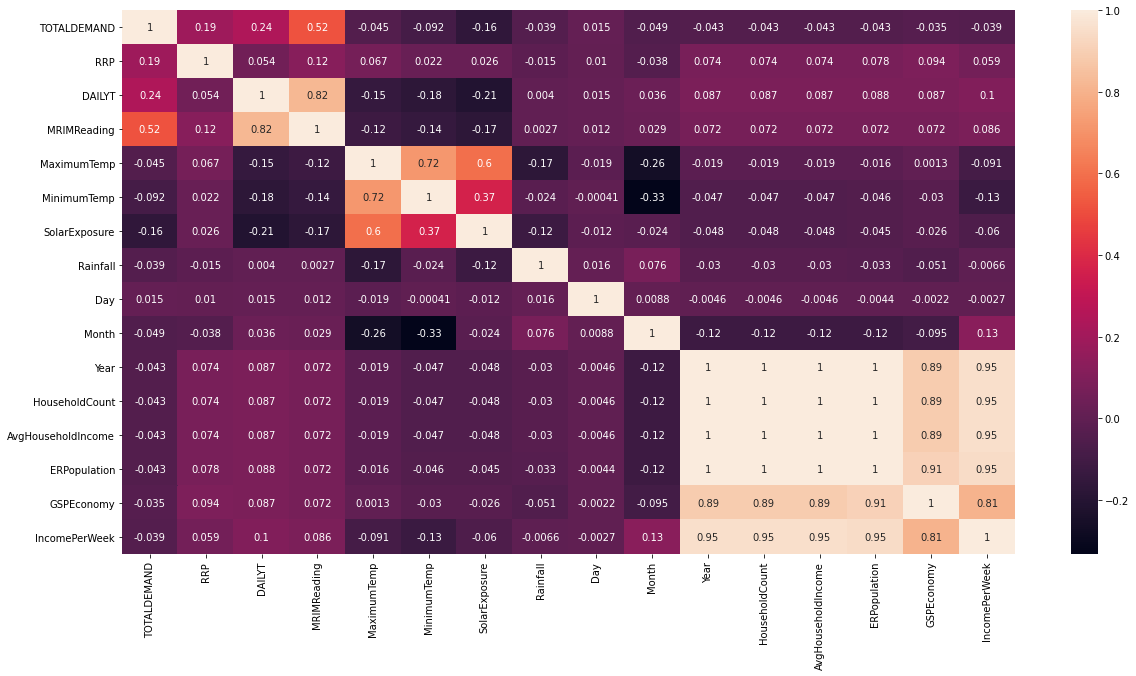

In [24]:
plt.figure(figsize=(20,10))
sns.heatmap(merged.corr(), annot = True)

In [25]:
# merged.to_csv('final.csv', index=False)

In [26]:
df = merged.drop(['ServiceProvider', 'DAILYT', 'MRIMReading', 'ProfileArea', 'Date'], axis = 1)
df['Day'] = df['Day'].astype(str)
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].astype(str)
df['Time'] = df['Time'].astype(str)
df = df.drop_duplicates().reset_index(drop=True)
df = df[~(df['SETTLEMENTDATE'] > '2020-10-05')][:-1]
df['ts'] = df.SETTLEMENTDATE.values.astype(np.int64) // 10 ** 9
# df = df.drop(['SETTLEMENTDATE'], axis = 1)
test = df.values

df

,SETTLEMENTDATE,TOTALDEMAND,RRP,Time,MaximumTemp,MinimumTemp,SolarExposure,Rainfall,Day,Month,...,PublicHoliday,DayOfWeek,WeekNumber,WeekTime,Season,SchoolHoliday,DayTime,LightCondition,IndustryHoliday,ts
0,2016-01-01 00:30:00,5197.34,35.52,00:30:00,24.2,19.8,22.0,0.0,1,1,...,Yes,Friday,53,Weekday,Summer,Yes,Night,Dark,Yes,1451608200
1,2016-01-01 01:00:00,4934.54,38.29,01:00:00,24.2,19.8,22.0,0.0,1,1,...,Yes,Friday,53,Weekday,Summer,Yes,Night,Dark,Yes,1451610000
2,2016-01-01 01:30:00,4721.32,29.30,01:30:00,24.2,19.8,22.0,0.0,1,1,...,Yes,Friday,53,Weekday,Summer,Yes,Night,Dark,Yes,1451611800
3,2016-01-01 02:00:00,4541.24,31.28,02:00:00,24.2,19.8,22.0,0.0,1,1,...,Yes,Friday,53,Weekday,Summer,Yes,Night,Dark,Yes,1451613600
4,2016-01-01 02:30:00,4344.18,23.87,02:30:00,24.2,19.8,22.0,0.0,1,1,...,Yes,Friday,53,Weekday,Summer,Yes,Night,Dark,Yes,1451615400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83466,2020-10-04 21:30:00,4021.88,10.47,21:30:00,29.5,13.5,8.4,0.0,4,10,...,No,Sunday,40,Weekend,Spring,Yes,Night,Dark,Yes,1601847000
83467,2020-10-04 22:00:00,3907.28,9.19,22:00:00,29.5,13.5,8.4,0.0,4,10,...,No,Sunday,40,Weekend,Spring,Yes,Night,Dark,Yes,1601848800
83468,2020-10-04 22:30:00,3771.22,1.35,22:30:00,29.5,13.5,8.4,0.0,4,10,...,No,Sunday,40,Weekend,Spring,Yes,Night,Dark,Yes,1601850600
83469,2020-10-04 23:00:00,3737.32,-0.48,23:00:00,29.5,13.5,8.4,0.0,4,10,...,No,Sunday,40,Weekend,Spring,Yes,Night,Dark,Yes,1601852400


In [27]:
df.dtypes

SETTLEMENTDATE        datetime64[ns]
TOTALDEMAND                  float64
RRP                          float64
Time                          object
MaximumTemp                  float64
MinimumTemp                  float64
SolarExposure                float64
Rainfall                     float64
Day                           object
Month                         object
Year                          object
HouseholdCount                 int64
AvgHouseholdIncome           float64
ERPopulation                   int64
GSPEconomy                     int64
IncomePerWeek                float64
PublicHoliday                 object
DayOfWeek                     object
WeekNumber                    object
WeekTime                      object
Season                        object
SchoolHoliday                 object
DayTime                       object
LightCondition                object
IndustryHoliday               object
ts                             int64
dtype: object

In [154]:
lb = LabelBinarizer()
dummies = pd.get_dummies(df)

df_train = df[df.SETTLEMENTDATE < '2020-03-16']
y_train = df_train.RRP.values
y_train = y_train.reshape(-1, 1)
y_train_scaler = StandardScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)
y_train = y_train.reshape(-1,)
print(y_train)
# y_train = y_train.astype('int')
# X_train = df_train.drop(['SETTLEMENTDATE', 'RRP'], axis = 1)

X_train = dummies[dummies.SETTLEMENTDATE < '2020-03-16']
X_train = X_train.drop(['SETTLEMENTDATE', 'ts', 'SchoolHoliday_Yes', 'SchoolHoliday_No', 'IndustryHoliday_Yes', 'IndustryHoliday_No'], axis = 1)
# X_train = X_train.astype('int')
X_train = X_train.values
# X_train = lb.fit_transform(X_train)

X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)


df_test = df[df.SETTLEMENTDATE > '2020-03-15']
y_test = df_test.RRP.values
y_test = y_test.reshape(-1, 1)
y_true = y_test
y_test_scaler = StandardScaler().fit(y_test)
y_test = y_test_scaler.transform(y_test)
y_test = y_test.reshape(-1,)
y_true = y_true.reshape(-1,)
# y_test = y_test.astype('int')
# X_test = df_test.drop(['SETTLEMENTDATE', 'RRP'], axis = 1)

X_test = dummies[dummies.SETTLEMENTDATE > '2020-03-15']
X_test = X_test.drop(['SETTLEMENTDATE', 'ts', 'SchoolHoliday_Yes', 'SchoolHoliday_No', 'IndustryHoliday_Yes', 'IndustryHoliday_No'], axis = 1)
# X_test = X_test.astype('int')
X_test = X_test.values
# X_test = lb.fit_transform(X_test)

X_test_scaler = StandardScaler().fit(X_test)
X_test = X_test_scaler.transform(X_test)


# y_train = lb.fit_transform(y_train)
# y_test = lb.transform(y_test)

[-0.18441716 -0.17406911 -0.20765358 ... -0.1806814  -0.18000897
 -0.17066957]


In [155]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[[ 0.26840811 -0.18441716  0.52501879 ...  1.18323522  1.00001356
  -1.00001356]
 [-0.03237108 -0.17406911  0.52501879 ...  1.18323522  1.00001356
  -1.00001356]
 [-0.27640509 -0.20765358  0.52501879 ...  1.18323522  1.00001356
  -1.00001356]
 ...
 [-0.93047392 -0.1806814  -0.33066429 ...  1.18323522  1.00001356
  -1.00001356]
 [-0.98236635 -0.18000897 -0.33066429 ...  1.18323522  1.00001356
  -1.00001356]
 [-0.79908332 -0.17066957 -0.33066429 ...  1.18323522  1.00001356
  -1.00001356]]
[[-0.72798381 -0.1439151   0.45441187 ...  1.18336099  1.00010214
  -1.00010214]
 [-0.90037449 -0.1676549   0.45441187 ...  1.18336099  1.00010214
  -1.00010214]
 [-1.01951022 -0.26854904  0.45441187 ...  1.18336099  1.00010214
  -1.00010214]
 ...
 [-1.35575878 -0.99672168  3.17387701 ...  1.18336099  1.00010214
  -1.00010214]
 [-1.39495425 -1.03849459  3.17387701 ...  1.18336099  1.00010214
  -1.00010214]
 [-1.13768629 -0.75475835  3.17387701 ...  1.18336099  1.00010214
  -1.00010214]]
[-0.18441716 -0.

In [169]:
reg = MLPRegressor(hidden_layer_sizes = (5, 5, 5, 5, 5, 5, 5),
                   activation = "relu",
                   random_state = 1,
                   max_iter = 5000).fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [170]:
y_pred_inverse = y_test_scaler.inverse_transform(y_pred)

In [171]:
print("R2 Score", (r2_score(y_test, y_pred)))
mse = mean_squared_error(y_test, y_pred)
print("MSE", (np.sqrt(mse)))

R2 Score 0.8724570023881535
MSE 0.3571316250513898


In [172]:

print("R2 Score", (r2_score(y_true, y_pred_inverse)))
mse = mean_squared_error(y_true, y_pred_inverse)
print("MSE", (np.sqrt(mse)))

R2 Score 0.8724570023881535
MSE 15.645326682784885


In [173]:
y_true

array([38.71, 37.67, 33.25, ...,  1.35, -0.48, 11.95])